# Machine Learning Model

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
def pipeline(path):
  df = (pd
    .read_csv(path, parse_dates=['date'])
    .drop_duplicates()
    .dropna())

  df['sales_channel'] = df['sales_channel'].str.capitalize()
  df = df.drop(df.query('invested < 1 or returned < 1').index)

  df['month'] = df['date'].dt.month_name()
  df['day_of_week'] = df['date'].dt.day_name()
  df['day_of_month'] = df['date'].dt.day

  return df.reset_index(drop=True)

In [3]:
df = pipeline('../data.csv')

In [4]:
df

,date,invested,returned,sales_channel,month,day_of_week,day_of_month
0,2020-01-01,74025.0,108610.0,Print advertising,January,Wednesday,1
1,2020-01-02,33993.0,137278.0,Tv,January,Thursday,2
2,2020-01-03,92217.0,28635.0,Social media,January,Friday,3
3,2020-01-04,79190.0,34487.0,Radio,January,Saturday,4
4,2020-01-05,40134.0,43405.0,Social media,January,Sunday,5
...,...,...,...,...,...,...,...
897,2022-12-27,34306.0,14006.0,Tv,December,Tuesday,27
898,2022-12-28,42139.0,37726.0,Print advertising,December,Wednesday,28
899,2022-12-29,87553.0,47059.0,Radio,December,Thursday,29
900,2022-12-30,20543.0,13637.0,Tv,December,Friday,30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           902 non-null    datetime64[ns]
 1   invested       902 non-null    float64       
 2   returned       902 non-null    float64       
 3   sales_channel  902 non-null    object        
 4   month          902 non-null    object        
 5   day_of_week    902 non-null    object        
 6   day_of_month   902 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 49.5+ KB


In [6]:
df = df.drop('date', axis=1)

In [7]:
minMaxScaler_fit = [(feature, MinMaxScaler().fit(df[feature].values.reshape(-1,1))) for feature in ['invested', 'returned']]

joblib.dump(minMaxScaler_fit, '../minMaxScaler_fit.jbl')
# exporting the fitted features from the data tu use later on
# the deployed model

for feature, scaler in minMaxScaler_fit:
  df[feature] = scaler.transform(df[feature].values.reshape(-1,1))

df.head()

,invested,returned,sales_channel,month,day_of_week,day_of_month
0,0.675147,0.758737,Print advertising,January,Wednesday,1
1,0.174434,0.979663,Tv,January,Thursday,2
2,0.902689,0.142421,Social media,January,Friday,3
3,0.739750,0.187519,Radio,January,Saturday,4
4,0.251245,0.256244,Social media,January,Sunday,5


In [8]:
labelEncoder_fit = [(feature, LabelEncoder().fit(df[feature])) for feature in df.select_dtypes('object').columns]

joblib.dump(labelEncoder_fit, '../labelEncoder_fit.jbl')
# exporting the fitted features from the data tu use later on
# the deployed model

for feature, fit in labelEncoder_fit:
  df[feature] = fit.transform(df[feature])
  # transforming the categorical features from string to 1,2,3...

df.head()

,invested,returned,sales_channel,month,day_of_week,day_of_month
0,0.675147,0.758737,0,4,6,1
1,0.174434,0.979663,3,4,4,2
2,0.902689,0.142421,2,4,0,3
3,0.739750,0.187519,1,4,2,4
4,0.251245,0.256244,2,4,3,5


In [9]:
df.describe()

,invested,returned,sales_channel,month,day_of_week,day_of_month
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.508875,0.502045,1.810421,5.506652,2.990022,15.832594
std,0.295612,0.291207,1.062206,3.443771,1.990240,8.843799
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.259415,0.253607,1.000000,2.250000,1.000000,8.000000
50%,0.498649,0.505391,2.000000,5.500000,3.000000,16.000000
75%,0.780269,0.753011,3.000000,9.000000,5.000000,23.000000
max,1.000000,1.000000,3.000000,11.000000,6.000000,31.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invested       902 non-null    float64
 1   returned       902 non-null    float64
 2   sales_channel  902 non-null    int64  
 3   month          902 non-null    int64  
 4   day_of_week    902 non-null    int64  
 5   day_of_month   902 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 42.4 KB


<AxesSubplot: >

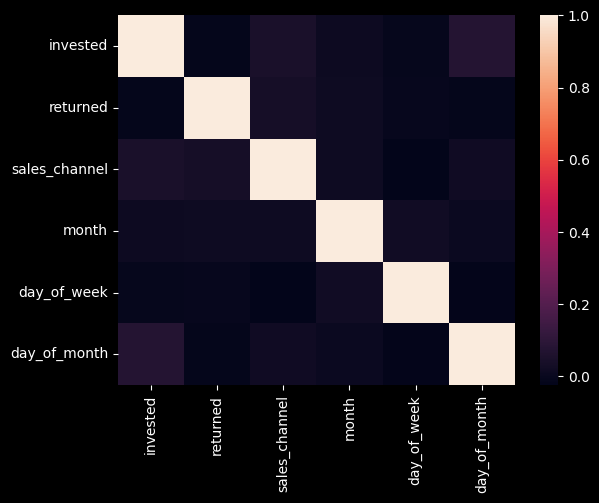

In [11]:
sns.heatmap(df.corr())

In [12]:
pd.Series([vif(df.values, i) for i in range(len(df.columns))], index=df.columns)

invested         3.440560
returned         3.309028
sales_channel    3.364365
month            3.097917
day_of_week      2.796845
day_of_month     3.529881
dtype: float64

In [13]:
x = df.drop('returned', axis=1)
y = df['returned']

In [14]:
x

,invested,sales_channel,month,day_of_week,day_of_month
0,0.675147,0,4,6,1
1,0.174434,3,4,4,2
2,0.902689,2,4,0,3
3,0.739750,1,4,2,4
4,0.251245,2,4,3,5
...,...,...,...,...,...
897,0.178349,3,2,5,27
898,0.276323,0,2,6,28
899,0.844353,1,2,4,29
900,0.006204,3,2,0,30


In [15]:
y

0      0.758737
1      0.979663
2      0.142421
3      0.187519
4      0.256244
         ...   
897    0.029685
898    0.212480
899    0.284403
900    0.026841
901    0.101855
Name: returned, Length: 902, dtype: float64

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=7)

In [17]:
print(f'x_train = {x_train.shape} | y_train = {y_train.shape} | x_test = {x_test.shape} | y_test = {y_test.shape}')

x_train = (721, 5) | y_train = (721,) | x_test = (181, 5) | y_test = (181,)


In [18]:
model = xgb.XGBRegressor(eval_metric='rmsle')

In [19]:
cross_scrore = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

minMaxScaler_fit[1][1].inverse_transform([[cross_scrore]])

array([[-36469.29729371]])

In [20]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
y_predict = model.predict(x_test)

In [22]:
minMaxScaler_fit[1][1].inverse_transform([y_predict[:10]])

array([[ 58651.5756056 , 102991.25078601, 100745.5375036 ,
         67321.48790753,  72567.94256613,  64730.76278639,
         63708.6090425 , 123591.93111229,  69296.04587704,
         47229.96050191]])

In [23]:
minMaxScaler_fit[1][1].inverse_transform([y_test[:10].values])

array([[ 99111., 129287.,  27170.,  12386.,  79806.,  48252., 127708.,
        126579.,  33369.,  57201.]])

In [24]:
rmse = metrics.mean_squared_error(y_test, y_predict, squared=False)

minMaxScaler_fit[1][1].inverse_transform([[rmse]])
# RMSE (root mean squared error) do set de teste

array([[52742.43028699]])

In [25]:
joblib.dump(model, '../model.jbl')

['model.jbl']